# ClavaDDPM: Multi-relational Data Synthesis with Cluster-guided Diffusion Models

Recent tabular data synthesis research has focused on single tables, while real-world applications often involve complex, interconnected tables. Existing methods for multi-relational data synthesis struggle with scalability and long-range dependencies. This paper introduces Cluster Latent Variable guided Denoising Diffusion Probabilistic Models (ClavaDDPM), using clustering labels to model inter-table relationships, particularly foreign key constraints. ClavaDDPM efficiently propagates latent variables across tables, capturing long-range dependencies. Evaluations show ClavaDDPM outperforms existing methods on multi-table data and remains competitive for single-table data.

In the following sections, we will delve deeper into the implementation of this method. The notebook is organized as follows:

1. [Imports and Setup]()


2. [Load Configuration]()


3. [Data Loading and Preprocessing]()
    
    
4. [Model Training]()
    
    4.1. [Clustring]()
    
    4.2. [PyTorch Training from Scratch]()
    
    4.3. [Loading Pretrained Models]()
    
    
5. [Model Sampling]()
    
    5.1. [Generating Data from Scratch]()
    
    5.2. [Loading Pre-Synthesized Data]()
    
    
6. [Model Evaluation]()

    6.1. [Multi-Table Metrics]()
    
    6.2. [Single-Table Metrics]()

# Imports and Setup

In this section, we import all necessary libraries and modules for setting up the environment. This includes libraries for logging, argument parsing, file path management, and configuration loading. We also import essential packages for data loading, model creation, and training, such as PyTorch and numpy, along with custom modules specific to the ClavaDDPM.

In [1]:
import os
import shutil
import json

from complex_pipeline import clava_clustering, clava_training, clava_load_pretrained, clava_synthesizing, clava_load_synthesized_data, clava_eval, load_configs
from pipeline_modules import load_multi_table
from gen_single_report import gen_single_report
from report_utils import get_multi_metadata

# Load Configuration

In this section, we establish the setup for model training by loading the configuration file, which includes the necessary parameters and settings for the training process. The configuration file, stored in `json` format, is read and parsed into a dictionary. We print out the entire configuration file in the code cell below and will explain the hyperparameters in more detail further down to clarify.

In [2]:
# Load config
config_path = 'configs/california_20_vector.json'
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

{
    "general": {
        "data_dir": "/fs01/projects/aieng/diffusion_bootcamp/data/tabular/raw_data/california_20/train",
        "exp_name": "california_20",
        "workspace_dir": "clavaDDPM_workspace/california",
        "sample_prefix": ""
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": {
            "individual": 25
        },
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 10000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_layers": [
            128,
            256,
            512,
            1024,
            512,
            256,
            128
 

# Data Loading and Preprocessing

In this section, we load and preprocess the dataset based on the configuration settings. We demonstrate the dataset's metadata and parent-child relationships to provide a clearer understanding of its structure. Following this, we perform clustering to preprocess the data, facilitating the training process for the ClavaDDPM model.

Table name: household, Train dataframe shape: (110900, 10), Total dataframe shape: (110900, 10)
Numerical (110900, 3)
Categorical (110900, 7)
Numerical data shape: (110900, 3)
Categorical data shape: (110900, 7)
Processing household table successfully!

Table name: individual, Train dataframe shape: (304510, 15), Total dataframe shape: (304510, 15)
Numerical (304510, 2)
Categorical (304510, 13)
Numerical data shape: (304510, 2)
Categorical data shape: (304510, 13)
Processing individual table successfully!

==================== We show the keys of the tables dictionary below ====================
dict_keys(['household', 'individual'])

==================== We show the relation order below ====================
[[None, 'household'], ['household', 'individual']]



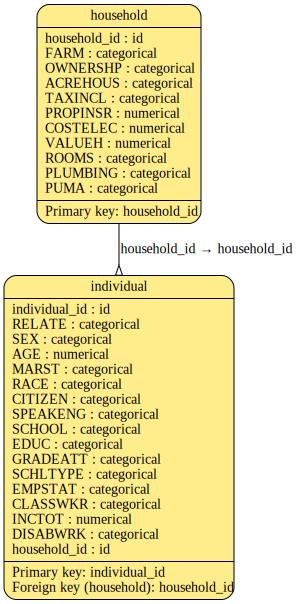

In [3]:
# Load multi-table dataset
# In this step, we load the multi-table dataset according to the 'dataset_meta.json' file located in the data_dir.
# We organize the multi-table dataset as a dictionary of tables, a list of relation orders, and a dictionary of dataset metadata.
tables, relation_order, dataset_meta = load_multi_table(configs['general']['data_dir'])

# Tables is a dictionary of the multi-table dataset
print("{} We show the keys of the tables dictionary below {}".format("="*20, "="*20))
print(tables.keys())
print("")

# Relation order is the topological order of the multi-table dataset
print("{} We show the relation order below {}".format("="*20, "="*20))
print(relation_order)
print("")

# Visualize the parent-child relationship within the multi-table dataset
multi_meta = get_multi_metadata(tables, relation_order)
multi_meta.visualize()

# Model Training

### Overview

<img src="assets/clavaDDPM.png" alt="ClavaDDPM Model Pipeline" width="960"/>

This section outlines the training process for the ClavaDDPM model. The diagram above, taken from the original paper, illustrates the main steps: (a) latent learning and table augmentation (steps 1-2), (b) training (steps 3-5), and (c) synthesis (steps 6-8). Specifically, the clustering process corresponds to latent learning and is used for table augmentation during training. The subsequent steps involve training the conditional diffusion models and the cluster classifier models. Following this, we implement the generation process, starting with sampling the table size and conducting conditional generation to satisfy the parent-child constraints (i.e., relation order).

We will implement and demonstrate each section below, step by step.

### Clustering
To get started, this paper first introduces relation-aware clustering to model parent-child constraints and leverages diffusion models for controlled tabular data synthesis. Specifically, [Gaussian Process Latent Variable Models (GPLVM)](https://pyro.ai/examples/gplvm.html) are used to discover low-dimensional manifolds in noisy, high-dimensional spaces. We run the clustering algorithm below to preprocess the data for training the ClavaDDPM model. Additionally, we empirically determine the distribution of table sizes in the dataset, which will be used in the later sampling process.

Mathematically, let $x$ and $y$ denote the child and parent tables, respectively. We consider $k$ clusters and model the distribution of $h = (x; \lambda y)$ with a Gaussian distribution around its corresponding centroid $c$, i.e.,
$$
P(h) = \sum_{c=1}^{k} P(c) P(h \mid c) = \sum_{c=1}^{k} \pi_c \mathcal{N}(h; \mu_c, \Sigma_c),
$$
where the coefficient $\lambda$ is the reweighting term called the parent scale. We opt for diagonal covariance, i.e., $\Sigma_c = \operatorname{diag}(\ldots, \sigma_l^2, \ldots)$, which, when properly optimized, immediately satisfies our assumptions that the foreign key groups are conditionally independent of their parent rows given the cluster. 

A summary of the important parameters for the clustering step includes:
- `parent_scale`: reweighting coefficient $\lambda$ for the parent table. The default value is 1.0. It is not a sensitive factor. Recommended range for tuning: 1.0 to 2.
- `num_clusters`: the number of clustering centers $k$ for child tables. The default is 20. Too few or too many clusters may compromise performance. Recommended range for tuning: 10 to 50.
- `clustering_method`: ClavaDDPM provides two ways to initialize GMM-based clustering. `gmm` uses `kmeans` for initialization, and the default method `both` uses `k-means++`. It is recommended to use `both`.

In [4]:
# Display important clustering parameters
params_clustering = configs['clustering']
print("{} We show the clustering parameters below {}".format("="*20, "="*20))
for key, val in params_clustering.items():
    print(f"{key}: {val}")
print("")

# Clustering on the multi-table dataset
# Output parameter: 'tables' contains the updated relational tables with data augmentation, where the latent variable is attached to the parent tables.
# Output parameter: 'all_group_lengths_prob_dicts' is a dictionary that computes group size distributions for each table, used in the sampling stage to determine the size of the tables to generate.
tables, all_group_lengths_prob_dicts = clava_clustering(tables, relation_order, save_dir, configs)

==================== We show the clustering parameters below ====================
parent_scale: 1.0
num_clusters: {'individual': 25}
clustering_method: both

Clustering checkpoint found, loading...


### PyTorch Training from Scratch
With the clustering results set, we can proceed to launch the training in PyTorch. Various callbacks are configured to monitor and save the model during training. The trainer is implemented using a custom PyTorch function, specifying parameters such as the number of epochs and checkpoints. The training process is then initiated, logging progress and completing the model's training.

In [ ]:
# Relation order is the topological order of the multi-table dataset
print("{} We show the relation order again, each line indicates one conditional generative model {}".format("="*20, "="*20))
print(relation_order)

# Launch training from scratch
models = clava_training(tables, relation_order, save_dir, configs)

### Loading Pretrained Models
If the training process from scratch takes too long, please run the following command to load pre-trained models and samples.

In [5]:
print(configs['general']['exp_name'], configs['general']['workspace_dir'])

california_20 clavaDDPM_workspace/california


In [6]:
# Use the pre-trained models
pretrained_dir = "/fs01/projects/aieng/diffusion_bootcamp/models/tabular/clavaDDPM/california_20_pretrained"
models = clava_load_pretrained(relation_order, pretrained_dir)

None -> household checkpoint found, loading...
household -> individual checkpoint found, loading...


# Model Sampling

### Overview
Upon completion of the training, the model is evaluated using the test dataset. To assess the model's performance, we first use the `clava_synthesizing` function to generate synthetic samples and showcase the results qualitatively. We initiate the generation process by sampling the table size (i.e., the number of rows per table) and performing conditional generation to meet the parent-child constraints (i.e., relation order). Quantitative evaluations will be conducted in the next section.

Important parameters for the sampling process include:
- `batch_size`: Mini-batch size for sampling.
- `classifier_scale` ($\eta$): Controls the magnitude of classifier gradients during guided sampling, balancing sample quality and conditional sampling accuracy. The default value is 1.0. When $\eta = 0$ (disabling classifier conditioning), single column densities (1-way) may improve but fail to capture long-range correlations. When $\eta = 2$, the increased conditioning weight significantly improves the modeling of multi-hop correlations compared to $\eta = 0$. Recommended tuning range: 0 to 2.

We also conduct a matching process to determine the parent-child table relationship of the generated data. This process uses an approximate nearest neighbor search-based matching technique, providing a universal solution to the multi-parent relational synthesis problem for a child table with multiple parents.

Important parameters are as follows:
- `num_matching_clusters`: Number of clusters used in the matching process.
- `matching_batch_size`: Mini-batch size for table matching.
- `unique_matching`: Boolean flag indicating if the matching result should be unique.
- `no_matching`: Boolean flag to disable the matching process.

In [7]:
# Display important sampling parameters
params_sampling = configs['sampling']
print("{} We show the important sampling parameters below {}".format("="*20, "="*20))
for key, val in params_sampling.items():
    print(f"{key}: {val}")
print("")


# Display important matching parameters
params_matching = configs['matching']
print("{} We show the important matching parameters below {}".format("="*20, "="*20))
for key, val in params_matching.items():
    print(f"{key}: {val}")
print("")

==================== We show the important sampling parameters below ====================
batch_size: 20000
classifier_scale: 1.0

==================== We show the important matching parameters below ====================
num_matching_clusters: 1
matching_batch_size: 1000
unique_matching: True
no_matching: False



### Generating Data from Scratch
To generate synthetic data from scratch, we run the following code cell. The synthetic data will be saved in the specified output directory.

In [8]:
# Generate synthetic data from scratch
cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
    tables, 
    relation_order, 
    save_dir, 
    all_group_lengths_prob_dicts, 
    models,
    configs,
    sample_scale=1 if not 'debug' in configs else configs['debug']['sample_scale']
)

Generating None -> household
Sample size: 11090
Sample timestep    0
Generating household -> individual
Sample size: 30451
Sample timestep    0
Sample timestep    0


In [18]:
# Cast int values that saved as string to int for further evaluation
for key in cleaned_tables.keys():
    for col in cleaned_tables[key].columns:
        if cleaned_tables[key][col].dtype == 'object':
            try:
                cleaned_tables[key][col] = cleaned_tables[key][col].astype(int)
            except ValueError:
                print(f"Column {col} cannot be converted to int.")

### Loading Pre-Synthesized Data
If the generation process takes too long, please run the following command to load pre-synthesized data. We provide the pre-synthesized data using the aforementioned pre-trained models.


In [6]:
# Load pre-synthesized data
pretrained_dir = "/fs01/projects/aieng/diffusion_bootcamp/models/tabular/clavaDDPM/california_20_pretrained"
cleaned_tables = clava_load_synthesized_data(tables.keys(), pretrained_dir)

Synthetic tables found, loading...
Synethic tables loaded!


# Model Evaluation

### Multi-Table Metrics
In this step, we quantitatively evaluate the generated tabular data by computing metrics to determine the accuracy of the predictions, specifically assessing how closely the generated data matches the observed samples in the reference dataset.

In particular, the critical multi-table metrics are as follows:

1. Pair-wise column correlation (k-hop): This metric measures the correlations between columns from tables at a distance k (e.g., 0-hop for columns within the same table, 1-hop for a column and a column from its parent or child table).

2. Average 2-way: This metric computes the average of all k-hop column-pair correlations, taking into account both short-range (k = 0) and longer-range (k > 0) dependencies.

We use the [SDV evaluation API](https://docs.sdv.dev/sdv/multi-table-data/evaluation/data-quality) to obtain these metrics. For more details about the computation process, refer to their documentation.

In [16]:
# Multi-table Evaluation
report = clava_eval(tables, save_dir, configs, relation_order, cleaned_tables)

generating multi-table report for clavaDDPM_workspace/california/california_20
Generating report ...
(4/4) Evaluating Intertable Trends: : 100%|██████████| 187/187 [00:53<00:00,  3.50it/s]

Overall Score: 95.05%

Properties:
- Column Shapes: 97.08%
- Column Pair Trends: 94.33%
- Cardinality: 96.23%
- Intertable Trends: 92.55%


In [17]:
# Print out the multi-table metrics
n_rows = 3
for key, val in report.items():
    if key in ['hop_relation', 'avg_scores', 'all_avg_score']:
        if key == 'hop_relation':
            print("{} metrics:".format(key))
            for k, v in val.items():
                if k > 0:
                    print("{:20}-hop column correlation, format '(Parent Table, Child Table, Column 1, Column 2): Correlation score'".format(k))
                else:
                    print("{:20}-hop column correlation, format '(Parent Table, Parent Table, Column 1, Column 2): Correlation score'".format(k))
                for i_row, (k2, v2) in enumerate(v.items()):
                    if i_row < n_rows:
                        print("{:20} {}: {}".format('', k2, v2))
                print("{:20} ...... other rows are omitted ......\n".format(''))
        elif key == 'avg_scores':
            print("{} metrics:".format(key))
            for k, v in val.items():
                print("{:20}-hop column correlation: {}".format(k, v))
        elif key == 'all_avg_score':
            print("{:20}: {}".format(key, val))

hop_relation metrics:
                   1-hop column correlation, format '(Parent Table, Child Table, Column 1, Column 2): Correlation score'
                     ('household', 'individual', 'FARM', 'RELATE'): 0.9474703463939407
                     ('household', 'individual', 'FARM', 'SEX'): 0.9959712406755361
                     ('household', 'individual', 'FARM', 'AGE'): 0.9575335052828032
                     ...... other rows are omitted ......

                   0-hop column correlation, format '(Parent Table, Parent Table, Column 1, Column 2): Correlation score'
                     ('household', 'household', 'FARM', 'OWNERSHP'): 0.9851758340847611
                     ('household', 'household', 'FARM', 'ACREHOUS'): 0.9971055004508567
                     ('household', 'household', 'FARM', 'TAXINCL'): 0.992741208295762
                     ...... other rows are omitted ......

avg_scores metrics:
                   1-hop column correlation: 0.925540958105889
                 

### Single Table Metrics
To study single table metrics please refer to `single_table_synthesis/evalutate_synthetic_data.ipynb` notebook. We highlight some of the key metrics below:
- Single Column Similarity Score: Compares the density distributions of individual columns in real and synthetic data to measure similarity.

- Pair-wise Correlation Score: Evaluates the preservation of relationships between pairs of columns, using correlation or contingency similarity.

- alpha-Precision and beta-Recall: Precision assesses the quality of synthetic data by how closely it matches real data points. Recall measures the diversity by how well synthetic data covers the variability of real data.

- Privacy Protection: Distance to Closest Record (DCR): Ensures synthetic data points are sufficiently distant from real data points to prevent privacy leakage.

- Detection: Classifier Two Sample Tests (C2ST): Measures the realism of synthetic data by evaluating if a machine learning model can distinguish it from real data.

In [20]:
# Prepare the synthetic data and reference data for single-table metric evaluation
shutil.copy(os.path.join(configs['general']['data_dir'], 'dataset_meta.json'), os.path.join(save_dir, 'dataset_meta.json'))
for table_name in tables.keys():
    shutil.copy(os.path.join(save_dir, table_name, '_final', f'{table_name}_synthetic.csv'), os.path.join(save_dir, f'{table_name}.csv'))
    # uncomment and run the following line if you want to use the pre-synthesized data
    # shutil.copy(os.path.join(pretrained_dir, table_name, '_final', f'{table_name}_synthetic.csv'), os.path.join(save_dir, f'{table_name}.csv'))

    shutil.copy(os.path.join(configs['general']['data_dir'], f'{table_name}_domain.json'), os.path.join(save_dir, f'{table_name}_domain.json'))

test_tables, _, _ = load_multi_table(save_dir, verbose=False)
real_tables, _, _ = load_multi_table(configs['general']['data_dir'], verbose=False)

# Single table metrics
for table_name in tables.keys():
    print(f'Generating report for {table_name}')
    real_data = real_tables[table_name]['df']
    syn_data = cleaned_tables[table_name]
    domain_dict = real_tables[table_name]['domain']

    if configs['general']['workspace_dir'] is not None:
        test_data = test_tables[table_name]['df']
    else:
        test_data = None

    gen_single_report(
        real_data, 
        syn_data,
        domain_dict,
        table_name,
        save_dir,
        alpha_beta_sample_size=200_000,
        test_data=test_data
    )

Generating report for household
alpha: 0.9911571986774872, beta: 0.4514637811842501

Computing MLE for column: FARM


100%|██████████| 36/36 [00:09<00:00,  3.69it/s]


MLE for column FARM: {'best_f1_scores': {'XGBClassifier': {'binary_f1': 0.8849557522123894, 'roc_auc': 0.9918671936429889, 'weighted_f1': 0.8855853070457522, 'accuracy': 0.9988277727682597}}, 'best_weighted_scores': {'XGBClassifier': {'binary_f1': 0.8849557522123894, 'roc_auc': 0.9918671936429889, 'weighted_f1': 0.8855853070457522, 'accuracy': 0.9988277727682597}}, 'best_auroc_scores': {'XGBClassifier': {'binary_f1': 0.5168539325842697, 'roc_auc': 0.9893076226758366, 'weighted_f1': 0.5195007471898127, 'accuracy': 0.9961226330027051}}, 'best_acc_scores': {'XGBClassifier': {'binary_f1': 0.4943820224719101, 'roc_auc': 0.9625064472352323, 'weighted_f1': 0.4971519447335248, 'accuracy': 0.9959422903516681}}, 'best_avg_scores': {'XGBClassifier': {'binary_f1': 0.8849557522123894, 'roc_auc': 0.9918671936429889, 'weighted_f1': 0.8855853070457522, 'accuracy': 0.9988277727682597}}}
Computing MLE for column: OWNERSHP


100%|██████████| 36/36 [00:10<00:00,  3.37it/s]


MLE for column OWNERSHP: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.9996578084840727, 'roc_auc': 0.9999997887422781, 'weighted_f1': 0.9995768697663949, 'accuracy': 0.999819657348963}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.9996578084840727, 'roc_auc': 0.9999997887422781, 'weighted_f1': 0.9995768697663949, 'accuracy': 0.999819657348963}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.9996578084840727, 'roc_auc': 0.9999997887422781, 'weighted_f1': 0.9995768697663949, 'accuracy': 0.999819657348963}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.9996578084840727, 'roc_auc': 0.9999997887422781, 'weighted_f1': 0.9995768697663949, 'accuracy': 0.999819657348963}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.9996578084840727, 'roc_auc': 0.9999997887422781, 'weighted_f1': 0.9995768697663949, 'accuracy': 0.999819657348963}}}
Computing MLE for column: ACREHOUS


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


MLE for column ACREHOUS: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.7404092327236974, 'roc_auc': 0.9357093793093606, 'weighted_f1': 0.6773376515076615, 'accuracy': 0.8678088367899008}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.7404092327236974, 'roc_auc': 0.9357093793093606, 'weighted_f1': 0.6773376515076615, 'accuracy': 0.8678088367899008}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.7503387499958336, 'roc_auc': 0.9404327046483504, 'weighted_f1': 0.6897850048529723, 'accuracy': 0.8727682596934175}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.7271193515348937, 'roc_auc': 0.8669722890484782, 'weighted_f1': 0.6618834177212167, 'accuracy': 0.8586113615870153}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.7404092327236974, 'roc_auc': 0.9357093793093606, 'weighted_f1': 0.6773376515076615, 'accuracy': 0.8678088367899008}}}
Computing MLE for column: TAXINCL


100%|██████████| 36/36 [00:19<00:00,  1.80it/s]


MLE for column TAXINCL: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.6855726271947412, 'roc_auc': 0.8947688591114725, 'weighted_f1': 0.6442680849316107, 'accuracy': 0.7551848512173129}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.6855726271947412, 'roc_auc': 0.8947688591114725, 'weighted_f1': 0.6442680849316107, 'accuracy': 0.7551848512173129}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.6855726271947412, 'roc_auc': 0.8947688591114725, 'weighted_f1': 0.6442680849316107, 'accuracy': 0.7551848512173129}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.6855726271947412, 'roc_auc': 0.8947688591114725, 'weighted_f1': 0.6442680849316107, 'accuracy': 0.7551848512173129}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.6855726271947412, 'roc_auc': 0.8947688591114725, 'weighted_f1': 0.6442680849316107, 'accuracy': 0.7551848512173129}}}
Computing MLE for column: PROPINSR


100%|██████████| 36/36 [00:11<00:00,  3.11it/s]


MLE for column PROPINSR: {'best_r2_scores': {'XGBRegressor': {'r2': 0.9793714880943298, 'explained_variance': 0.9793722033500671, 'MAE': 0.12527745962142944, 'RMSE': 0.2761757969856262}}, 'best_rmse_scores': {'XGBRegressor': {'r2': 0.9793714880943298, 'explained_variance': 0.9793722033500671, 'MAE': 0.12527745962142944, 'RMSE': 0.2761757969856262}}}
Computing MLE for column: COSTELEC


100%|██████████| 36/36 [00:12<00:00,  2.99it/s]


MLE for column COSTELEC: {'best_r2_scores': {'XGBRegressor': {'r2': 0.3258848786354065, 'explained_variance': 0.32588499784469604, 'MAE': 0.6355072259902954, 'RMSE': 0.8987739682197571}}, 'best_rmse_scores': {'XGBRegressor': {'r2': 0.3258848786354065, 'explained_variance': 0.32588499784469604, 'MAE': 0.6355072259902954, 'RMSE': 0.8987739682197571}}}
Computing MLE for column: VALUEH


100%|██████████| 36/36 [00:12<00:00,  2.98it/s]


MLE for column VALUEH: {'best_r2_scores': {'XGBRegressor': {'r2': 0.9575589895248413, 'explained_variance': 0.9575711488723755, 'MAE': 0.07848818600177765, 'RMSE': 0.21477341651916504}}, 'best_rmse_scores': {'XGBRegressor': {'r2': 0.9575589895248413, 'explained_variance': 0.9575711488723755, 'MAE': 0.07848818600177765, 'RMSE': 0.21477341651916504}}}
Computing MLE for column: ROOMS


100%|██████████| 36/36 [00:47<00:00,  1.31s/it]


MLE for column ROOMS: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.38239924914820084, 'roc_auc': 0.8360150268738857, 'weighted_f1': 0.3833936187452743, 'accuracy': 0.38575293056807936}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.38239924914820084, 'roc_auc': 0.8360150268738857, 'weighted_f1': 0.3833936187452743, 'accuracy': 0.38575293056807936}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.35587363759057866, 'roc_auc': 0.8223949352200485, 'weighted_f1': 0.3572147167319862, 'accuracy': 0.36014427412082956}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.35178662510629055, 'roc_auc': 0.8192109302103372, 'weighted_f1': 0.3531785668041204, 'accuracy': 0.3550045085662759}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.38239924914820084, 'roc_auc': 0.8360150268738857, 'weighted_f1': 0.3833936187452743, 'accuracy': 0.38575293056807936}}}
Computing MLE for column: PLUMBING


100%|██████████| 36/36 [00:12<00:00,  2.85it/s]


MLE for column PLUMBING: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.7125390405811932, 'roc_auc': 0.9354848289739485, 'weighted_f1': 0.5711262896158219, 'accuracy': 0.9962128043282237}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.7125390405811932, 'roc_auc': 0.9354848289739485, 'weighted_f1': 0.5711262896158219, 'accuracy': 0.9962128043282237}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.7125390405811932, 'roc_auc': 0.9517297503284597, 'weighted_f1': 0.5711262896158219, 'accuracy': 0.9962128043282237}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.7125390405811932, 'roc_auc': 0.9354848289739485, 'weighted_f1': 0.5711262896158219, 'accuracy': 0.9962128043282237}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.7125390405811932, 'roc_auc': 0.9517297503284597, 'weighted_f1': 0.5711262896158219, 'accuracy': 0.9962128043282237}}}
Computing MLE for column: PUMA


100%|██████████| 36/36 [06:34<00:00, 10.95s/it]


MLE for column PUMA: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.09723972898010975, 'roc_auc': 0.8467634680727091, 'weighted_f1': 0.09723688849976028, 'accuracy': 0.10153291253381425}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.09723972898010975, 'roc_auc': 0.8467634680727091, 'weighted_f1': 0.09723688849976028, 'accuracy': 0.10153291253381425}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.09723972898010975, 'roc_auc': 0.8467634680727091, 'weighted_f1': 0.09723688849976028, 'accuracy': 0.10153291253381425}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.09723972898010975, 'roc_auc': 0.8467634680727091, 'weighted_f1': 0.09723688849976028, 'accuracy': 0.10153291253381425}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.09723972898010975, 'roc_auc': 0.8467634680727091, 'weighted_f1': 0.09723688849976028, 'accuracy': 0.10153291253381425}}}
score: 0.9930821976509988
Detection Score: 0.9930821976509988

Generating report for individual
===========

100%|██████████| 36/36 [00:52<00:00,  1.47s/it]


MLE for column RELATE: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.3599454384257437, 'roc_auc': 0.9036159502456131, 'weighted_f1': 0.3068139256949053, 'accuracy': 0.757862826828344}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.3599454384257437, 'roc_auc': 0.9036159502456131, 'weighted_f1': 0.3068139256949053, 'accuracy': 0.757862826828344}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.3591266254820389, 'roc_auc': 0.8912084775236777, 'weighted_f1': 0.3045996580428588, 'accuracy': 0.7661045850701023}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.3599454384257437, 'roc_auc': 0.9036159502456131, 'weighted_f1': 0.3068139256949053, 'accuracy': 0.757862826828344}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.3599454384257437, 'roc_auc': 0.9036159502456131, 'weighted_f1': 0.3068139256949053, 'accuracy': 0.757862826828344}}}
Computing MLE for column: SEX


100%|██████████| 36/36 [00:15<00:00,  2.32it/s]


MLE for column SEX: {'best_f1_scores': {'XGBClassifier': {'binary_f1': 0.7613517372679677, 'roc_auc': 0.8589860289874107, 'weighted_f1': 0.7625026713095745, 'accuracy': 0.7625047366426677}}, 'best_weighted_scores': {'XGBClassifier': {'binary_f1': 0.6817608347256794, 'roc_auc': 0.7981959136727245, 'weighted_f1': 0.7037331453117702, 'accuracy': 0.7052860932171277}}, 'best_auroc_scores': {'XGBClassifier': {'binary_f1': 0.6817608347256794, 'roc_auc': 0.7981959136727245, 'weighted_f1': 0.7037331453117702, 'accuracy': 0.7052860932171277}}, 'best_acc_scores': {'XGBClassifier': {'binary_f1': 0.6817608347256794, 'roc_auc': 0.7981959136727245, 'weighted_f1': 0.7037331453117702, 'accuracy': 0.7052860932171277}}, 'best_avg_scores': {'XGBClassifier': {'binary_f1': 0.6817608347256794, 'roc_auc': 0.7981959136727245, 'weighted_f1': 0.7037331453117702, 'accuracy': 0.7052860932171277}}}
Computing MLE for column: AGE


100%|██████████| 36/36 [00:21<00:00,  1.64it/s]


MLE for column AGE: {'best_r2_scores': {'XGBRegressor': {'r2': 0.9694535732269287, 'explained_variance': 0.9694582223892212, 'MAE': 0.11737879365682602, 'RMSE': 0.17218434810638428}}, 'best_rmse_scores': {'XGBRegressor': {'r2': 0.9694535732269287, 'explained_variance': 0.9694582223892212, 'MAE': 0.11737879365682602, 'RMSE': 0.17218434810638428}}}
Computing MLE for column: MARST


100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


MLE for column MARST: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.45374687392161545, 'roc_auc': 0.9280500654962647, 'weighted_f1': 0.385175617315248, 'accuracy': 0.8118605532398636}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.45374687392161545, 'roc_auc': 0.9280500654962647, 'weighted_f1': 0.385175617315248, 'accuracy': 0.8118605532398636}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.4403651410348286, 'roc_auc': 0.9247948096181116, 'weighted_f1': 0.3718340783668969, 'accuracy': 0.7975874700012631}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.4370863137734006, 'roc_auc': 0.9172930872894048, 'weighted_f1': 0.36848683344469385, 'accuracy': 0.7938928887204749}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.45516647622177037, 'roc_auc': 0.9346240856507534, 'weighted_f1': 0.38837889207067444, 'accuracy': 0.8033977516736137}}}
Computing MLE for column: RACE


100%|██████████| 36/36 [00:59<00:00,  1.67s/it]


MLE for column RACE: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.2903341100111245, 'roc_auc': 0.8420860021535497, 'weighted_f1': 0.24928545625847942, 'accuracy': 0.6720032840722496}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.2903341100111245, 'roc_auc': 0.8420860021535497, 'weighted_f1': 0.24928545625847942, 'accuracy': 0.6720032840722496}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.24732183493345306, 'roc_auc': 0.7760385760191765, 'weighted_f1': 0.2036976928659603, 'accuracy': 0.6546671719085512}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.2903341100111245, 'roc_auc': 0.8420860021535497, 'weighted_f1': 0.24928545625847942, 'accuracy': 0.6720032840722496}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.2867219542383622, 'roc_auc': 0.8284883910318236, 'weighted_f1': 0.2435099523255051, 'accuracy': 0.6859290135152204}}}
Computing MLE for column: CITIZEN


100%|██████████| 36/36 [00:32<00:00,  1.11it/s]


MLE for column CITIZEN: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.4999642191624477, 'roc_auc': 0.8718951978479691, 'weighted_f1': 0.3938911613909234, 'accuracy': 0.833554376657825}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.4999642191624477, 'roc_auc': 0.8718951978479691, 'weighted_f1': 0.3938911613909234, 'accuracy': 0.833554376657825}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.668601636653466, 'roc_auc': 0.9665804465781429, 'weighted_f1': 0.5801151829284447, 'accuracy': 0.9366237211064797}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.4999642191624477, 'roc_auc': 0.8718951978479691, 'weighted_f1': 0.3938911613909234, 'accuracy': 0.833554376657825}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.668601636653466, 'roc_auc': 0.9665804465781429, 'weighted_f1': 0.5801151829284447, 'accuracy': 0.9366237211064797}}}
Computing MLE for column: SPEAKENG


100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


MLE for column SPEAKENG: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.6415889712535575, 'roc_auc': 0.923981678556138, 'weighted_f1': 0.6181618789329719, 'accuracy': 0.7685676392572944}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.6415889712535575, 'roc_auc': 0.923981678556138, 'weighted_f1': 0.6181618789329719, 'accuracy': 0.7685676392572944}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.5611039039716403, 'roc_auc': 0.9086286944450338, 'weighted_f1': 0.530021448765659, 'accuracy': 0.7293482379689277}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.5333295568718929, 'roc_auc': 0.9011455096412754, 'weighted_f1': 0.4998816289430671, 'accuracy': 0.7184539598332702}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.6415889712535575, 'roc_auc': 0.923981678556138, 'weighted_f1': 0.6181618789329719, 'accuracy': 0.7685676392572944}}}
Computing MLE for column: SCHOOL


100%|██████████| 36/36 [00:10<00:00,  3.40it/s]


MLE for column SCHOOL: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.9999446343410399, 'roc_auc': 0.9999613120959667, 'weighted_f1': 0.9999485291293444, 'accuracy': 0.999936844764431}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.9999446343410399, 'roc_auc': 0.9999613120959667, 'weighted_f1': 0.9999485291293444, 'accuracy': 0.999936844764431}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.9999446343410399, 'roc_auc': 0.9999613120959667, 'weighted_f1': 0.9999485291293444, 'accuracy': 0.999936844764431}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.9999446343410399, 'roc_auc': 0.9999613120959667, 'weighted_f1': 0.9999485291293444, 'accuracy': 0.999936844764431}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.9999446343410399, 'roc_auc': 0.9999613120959667, 'weighted_f1': 0.9999485291293444, 'accuracy': 0.999936844764431}}}
Computing MLE for column: EDUC


100%|██████████| 36/36 [01:15<00:00,  2.09s/it]


MLE for column EDUC: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.7362097775789131, 'roc_auc': 0.9648958099488617, 'weighted_f1': 0.7337490219532778, 'accuracy': 0.7640836175318934}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.7362097775789131, 'roc_auc': 0.9648958099488617, 'weighted_f1': 0.7337490219532778, 'accuracy': 0.7640836175318934}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.3427278884093612, 'roc_auc': 0.843498313939297, 'weighted_f1': 0.32949731769945384, 'accuracy': 0.5203044082354428}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.3427677839675567, 'roc_auc': 0.8434977973403133, 'weighted_f1': 0.32953597664619044, 'accuracy': 0.5203675634710118}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.4341040790041678, 'roc_auc': 0.9066303775437388, 'weighted_f1': 0.422448701948396, 'accuracy': 0.5824175824175825}}}
Computing MLE for column: GRADEATT


100%|██████████| 36/36 [00:32<00:00,  1.12it/s]


MLE for column GRADEATT: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.7886018844172633, 'roc_auc': 0.996161651671823, 'weighted_f1': 0.7644556170132384, 'accuracy': 0.9587280535556397}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.7886018844172633, 'roc_auc': 0.996161651671823, 'weighted_f1': 0.7644556170132384, 'accuracy': 0.9587280535556397}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.8252114810588855, 'roc_auc': 0.9973366659546572, 'weighted_f1': 0.8052365127808265, 'accuracy': 0.9660540608816471}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.8252114810588855, 'roc_auc': 0.9973366659546572, 'weighted_f1': 0.8052365127808265, 'accuracy': 0.9660540608816471}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.7886018844172633, 'roc_auc': 0.996161651671823, 'weighted_f1': 0.7644556170132384, 'accuracy': 0.9587280535556397}}}
Computing MLE for column: SCHLTYPE


100%|██████████| 36/36 [00:17<00:00,  2.09it/s]


MLE for column SCHLTYPE: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.8289360864518754, 'roc_auc': 0.9882445983316013, 'weighted_f1': 0.7839553667295214, 'accuracy': 0.9709801692560314}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.8289360864518754, 'roc_auc': 0.9882445983316013, 'weighted_f1': 0.7839553667295214, 'accuracy': 0.9709801692560314}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.7318705898840707, 'roc_auc': 0.9795606365944923, 'weighted_f1': 0.660031391173482, 'accuracy': 0.9639383604900846}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.7534644656944118, 'roc_auc': 0.9828785161807146, 'weighted_f1': 0.6876203721305059, 'accuracy': 0.9653277756726033}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.8289360864518754, 'roc_auc': 0.9882445983316013, 'weighted_f1': 0.7839553667295214, 'accuracy': 0.9709801692560314}}}
Computing MLE for column: EMPSTAT


100%|██████████| 36/36 [00:25<00:00,  1.43it/s]


MLE for column EMPSTAT: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.6683927744256831, 'roc_auc': 0.9065293601858028, 'weighted_f1': 0.5995174589234441, 'accuracy': 0.8799418971832765}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.6683927744256831, 'roc_auc': 0.9065293601858028, 'weighted_f1': 0.5995174589234441, 'accuracy': 0.8799418971832765}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.6760597313304406, 'roc_auc': 0.9460196113680498, 'weighted_f1': 0.6060687366409536, 'accuracy': 0.889920424403183}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.6683927744256831, 'roc_auc': 0.9065293601858028, 'weighted_f1': 0.5995174589234441, 'accuracy': 0.8799418971832765}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.6760597313304406, 'roc_auc': 0.9460196113680498, 'weighted_f1': 0.6060687366409536, 'accuracy': 0.889920424403183}}}
Computing MLE for column: CLASSWKR


100%|██████████| 36/36 [00:27<00:00,  1.31it/s]


MLE for column CLASSWKR: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.6488786300202758, 'roc_auc': 0.9421879279446861, 'weighted_f1': 0.5441996009188458, 'accuracy': 0.8803839838322597}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.9555358891159939, 'roc_auc': 0.9897642538563174, 'weighted_f1': 0.9458102978341811, 'accuracy': 0.9752115700391563}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.6243559574524559, 'roc_auc': 0.9239322762833803, 'weighted_f1': 0.5129998153403769, 'accuracy': 0.8714159403814576}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.6488786300202758, 'roc_auc': 0.9421879279446861, 'weighted_f1': 0.5441996009188458, 'accuracy': 0.8803839838322597}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.6488786300202758, 'roc_auc': 0.9421879279446861, 'weighted_f1': 0.5441996009188458, 'accuracy': 0.8803839838322597}}}
Computing MLE for column: INCTOT


100%|██████████| 36/36 [00:25<00:00,  1.42it/s]


MLE for column INCTOT: {'best_r2_scores': {'XGBRegressor': {'r2': 0.7170222997665405, 'explained_variance': 0.717024564743042, 'MAE': 0.4974813163280487, 'RMSE': 0.7357878088951111}}, 'best_rmse_scores': {'XGBRegressor': {'r2': 0.7170222997665405, 'explained_variance': 0.717024564743042, 'MAE': 0.4974813163280487, 'RMSE': 0.7357878088951111}}}
Computing MLE for column: DISABWRK


100%|██████████| 36/36 [00:22<00:00,  1.58it/s]


MLE for column DISABWRK: {'best_f1_scores': {'XGBClassifier': {'macro_f1': 0.9662469413553453, 'roc_auc': 0.9879564123756507, 'weighted_f1': 0.9592611291795774, 'accuracy': 0.9806744979158772}}, 'best_weighted_scores': {'XGBClassifier': {'macro_f1': 0.9662469413553453, 'roc_auc': 0.9879564123756507, 'weighted_f1': 0.9592611291795774, 'accuracy': 0.9806744979158772}}, 'best_auroc_scores': {'XGBClassifier': {'macro_f1': 0.6496885939384592, 'roc_auc': 0.8840948477742167, 'weighted_f1': 0.5583493408046839, 'accuracy': 0.8835101679929266}}, 'best_acc_scores': {'XGBClassifier': {'macro_f1': 0.6822514075774496, 'roc_auc': 0.9185048350328108, 'weighted_f1': 0.6005042450715715, 'accuracy': 0.8890362511052167}}, 'best_avg_scores': {'XGBClassifier': {'macro_f1': 0.9662469413553453, 'roc_auc': 0.9879564123756507, 'weighted_f1': 0.9592611291795774, 'accuracy': 0.9806744979158772}}}
score: 0.9268946898889082
Detection Score: 0.9268946898889082



## References

**Pang, Wei, et al.** "ClavaDDPM: Multi-relational Data Synthesis with Cluster-guided Diffusion Models." *preprint* (2024).

**GitHub Repository:** [ClavaDDPM](https://github.com/weipang142857/ClavaDDPM)